# **데이터 불러오기**

In [7]:
import pandas as pd
import numpy as np
from time import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from tensorflow.keras.layers import Dropout,Flatten
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()

early_stopping = EarlyStopping()

train_features=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

train_features = train_features.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
train_features = train_features.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
train_features = train_features.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))

test = test.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
test = test.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
test = test.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))
start = time()



In [8]:
x_train = []

train_features.shape

for uid in tqdm(train_features['id'].unique()):
    temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)

x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    
for _ in range(10):
    aug(x_train, 0, int(random.random()*600))


100%|██████████| 782/782 [00:00<00:00, 991.78it/s] 


In [13]:
X=tf.reshape(x_train,[-1, 600,9])
y = tf.keras.utils.to_categorical(train_labels['label'])  
X_train,X_valid = train_test_split(X.iloc[:,2:],test_size=0.3,random_state=0)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([   4, 1328, 2678, ..., 1653, 2607, 2732])

In [11]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(32))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(61, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(X,y, epochs= 100, batch_size=128, validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 8s 57ms/step - loss: 3.8885 - accuracy: 0.1431 - val_loss: 3.0144 - val_accuracy: 0.4976
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 3.1323 - accuracy: 0.4743 - val_loss: 2.7297 - val_accuracy: 0.4976
Epoch 3/100
20/20 [==============================] - 1s 28ms/step - loss: 2.9929 - accuracy: 0.4788 - val_loss: 2.6932 - val_accuracy: 0.4976
Epoch 4/100
20/20 [==============================] - 1s 27ms/step - loss: 2.9404 - accuracy: 0.4781 - val_loss: 2.6375 - val_accuracy: 0.4976
Epoch 5/100
20/20 [==============================] - 1s 28ms/step - loss: 2.8842 - accuracy: 0.4772 - val_loss: 2.5908 - val_accuracy: 0.4976
Epoch 6/100
20/20 [==============================] - 1s 28ms/step - loss: 2.7657 - accuracy: 0.4974 - val_loss: 2.5908 - val_accuracy: 0.5152
Epoch 7/100
20/20 [==============================] - 1s 29ms/step - loss: 2.7782 - accuracy: 0.4817 - val_loss: 2.4845 - val_accuracy: 0.5072
Epoch 


When hidden layers are 2, Elapse training time : 196.10629558563232 seconds

98/98 [==============================] - 1s 12ms/step - loss: 0.8625 - accuracy: 0.7498

Loss : 0.862519
Accuracy : 74.976%
When hidden layers are 2, Elapse test time : 1.2401065826416016 seconds


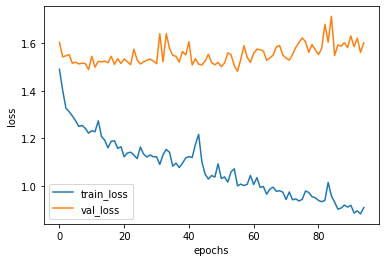

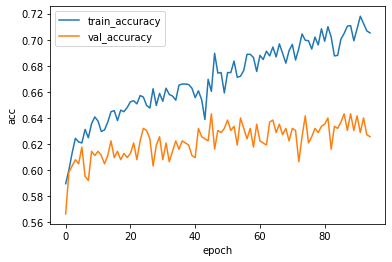

In [89]:
print(f'\nWhen hidden layers are 2, Elapse training time : {time() - start} seconds\n')
start = time()
loss_and_metrics = model.evaluate(X, y)
print(f'\nLoss : {loss_and_metrics[0]:.6}')
print(f'Accuracy : {loss_and_metrics[1]*100:.6}%')
print(f'When hidden layers are 2, Elapse test time : {time() - start} seconds')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [91]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600,3])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('submission.csv', index=False)